# Summary

In this File, we first setup the basic skeleton which would be the first step in building and running our model.


**Target**


1.   Get the basis working neural network for MNIST up and running
2.   Import Data & Do Data processing / Transformations
3.   Set Data Loader
4.   Set Basic Working Code
5.   Set Basic Training  & Test Loop


**Result**

*   Total Model Parameters :  6379786 i.e. ~6.4M
*   Best Train Accuracy :  100.0
*   Best Test Accuracy :  99.36
*   Number of Epochs with test accuracy above 99.4% threshold: 0


**Analysis**


1.   Successfully created a working model for MNIST
2.   The Test accuracy never crossed the required threshold of 99.4%
3.   Model hit the highest train accuracy of 100%, that means there's some element of overfitting in the training phase
4.   The # of parameters are very high, much higher than the requirement of 8K parameters
5.   The last couple convolution layers are responsible for the explosion of number of parameters at the end



## Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
# We use this experimental data to identify the mean and std dev of the dataset

# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


## Data Import & transformation

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


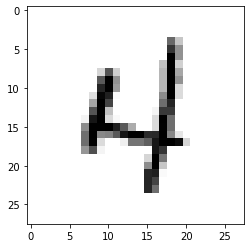

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


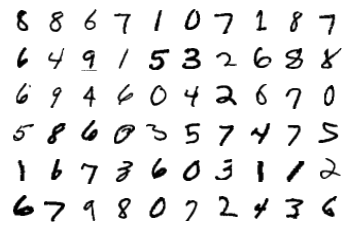

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Model

Defining the model & Initialising it

In [ ]:
# We use padding to ensure that the size of the layer remains same

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) # Input - 28 x 28 x 1 | Output - 28 x 28 x 32 | RF - 3 | Kernel - 3 x 3 x 1 x 32
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # Input - 28 x 28 x 32 | Output - 28 x 28 x 64 | RF - 5 | Kernel - 3 x 3 x 32 x 64
        self.pool1 = nn.MaxPool2d(2, 2) # Input - 28 x 28 x 64 | Output - 14 x 14 x 64 | RF - 10 | Kernel - 2 x 2 x 64
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1) # Input - 14 x 14 x 64 | Output - 14 x 14 x 128 | RF - 12 | Kernel - 3 x 3 x 64 x 128
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1) # Input - 14 x 14 x 128 | Output - 14 x 14 x 256 | RF - 14 | Kernel - 3 x 3 x 128 x 256
        self.pool2 = nn.MaxPool2d(2, 2) # Input - 14 x 14 x 256 | Output - 7 x 7 x 256 | RF - 28 | Kernel - Kernel - 2 x 2 x 256
        self.conv5 = nn.Conv2d(256, 512, 3) # Input - 7 x 7 x 256 | Output - 5 x 5 x 512 | RF - 30 | Kernel - 3 x 3 x 256 x 512
        self.conv6 = nn.Conv2d(512, 1024, 3) # Input - 5 x 5 x 512 | Output - 3 x 3 x 1024 | RF - 32 | Kernel - 3 x 3 x 512 x 1024
        self.conv7 = nn.Conv2d(1024, 10, 3) # Input - 3 x 3 x 1024 | Output - 1 x 1 x 10 | RF - 34 | Kernel - 3 x 3 x 1024 x 10

        # We start with an input image of size 28 x 28 and a receptive field (RF) of 3 and go to an output of 1x1 
        # and receptive field of 34

        # Layer is a convolution. # of layers = # of convolutions

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        # x = F.relu(self.conv7(x))
        x = self.conv7(x)
        x = x.view(-1, 10) #1x1x10> 10
        return F.log_softmax(x, dim=-1)

## Model Parameters

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (

## Training & Testing the Neural Network

Run the model and check 

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Testing our model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.04967624321579933 Batch_id=468 Accuracy=88.04: 100%|██████████| 469/469 [00:19<00:00, 23.54it/s]



Test set: Average loss: 0.0632, Accuracy: 9798/10000 (97.98%)

EPOCH: 1


Loss=0.021092193201184273 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:21<00:00, 22.04it/s]



Test set: Average loss: 0.0351, Accuracy: 9878/10000 (98.78%)

EPOCH: 2


Loss=0.049551159143447876 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:17<00:00, 26.54it/s]



Test set: Average loss: 0.0357, Accuracy: 9874/10000 (98.74%)

EPOCH: 3


Loss=0.006296547595411539 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:17<00:00, 26.55it/s]



Test set: Average loss: 0.0289, Accuracy: 9902/10000 (99.02%)

EPOCH: 4


Loss=0.008456552401185036 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:17<00:00, 26.46it/s]



Test set: Average loss: 0.0283, Accuracy: 9907/10000 (99.07%)

EPOCH: 5


Loss=0.01032052282243967 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:17<00:00, 26.33it/s]



Test set: Average loss: 0.0265, Accuracy: 9914/10000 (99.14%)

EPOCH: 6


Loss=0.047313038259744644 Batch_id=468 Accuracy=99.70: 100%|██████████| 469/469 [00:19<00:00, 23.63it/s]



Test set: Average loss: 0.0276, Accuracy: 9915/10000 (99.15%)

EPOCH: 7


Loss=0.01726633496582508 Batch_id=468 Accuracy=99.73: 100%|██████████| 469/469 [00:17<00:00, 26.32it/s]



Test set: Average loss: 0.0309, Accuracy: 9907/10000 (99.07%)

EPOCH: 8


Loss=0.0019352850504219532 Batch_id=468 Accuracy=99.75: 100%|██████████| 469/469 [00:18<00:00, 25.38it/s]



Test set: Average loss: 0.0283, Accuracy: 9920/10000 (99.20%)

EPOCH: 9


Loss=0.0007511132280342281 Batch_id=468 Accuracy=99.81: 100%|██████████| 469/469 [00:17<00:00, 26.47it/s]



Test set: Average loss: 0.0303, Accuracy: 9918/10000 (99.18%)

EPOCH: 10


Loss=0.0008645780035294592 Batch_id=468 Accuracy=99.82: 100%|██████████| 469/469 [00:18<00:00, 25.94it/s]



Test set: Average loss: 0.0256, Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Loss=0.0012310479069128633 Batch_id=468 Accuracy=99.89: 100%|██████████| 469/469 [00:18<00:00, 25.94it/s]



Test set: Average loss: 0.0338, Accuracy: 9924/10000 (99.24%)

EPOCH: 12


Loss=2.7006250093108974e-05 Batch_id=468 Accuracy=99.91: 100%|██████████| 469/469 [00:17<00:00, 26.68it/s]



Test set: Average loss: 0.0275, Accuracy: 9927/10000 (99.27%)

EPOCH: 13


Loss=0.00033248672843910754 Batch_id=468 Accuracy=99.96: 100%|██████████| 469/469 [00:17<00:00, 26.40it/s]



Test set: Average loss: 0.0345, Accuracy: 9921/10000 (99.21%)

EPOCH: 14


Loss=1.0597975233395118e-05 Batch_id=468 Accuracy=99.93: 100%|██████████| 469/469 [00:17<00:00, 26.52it/s]



Test set: Average loss: 0.0306, Accuracy: 9930/10000 (99.30%)

EPOCH: 15


Loss=0.0010595845524221659 Batch_id=468 Accuracy=99.94: 100%|██████████| 469/469 [00:17<00:00, 26.51it/s]



Test set: Average loss: 0.0321, Accuracy: 9916/10000 (99.16%)

EPOCH: 16


Loss=7.228854519780725e-05 Batch_id=468 Accuracy=99.92: 100%|██████████| 469/469 [00:17<00:00, 26.48it/s]



Test set: Average loss: 0.0274, Accuracy: 9930/10000 (99.30%)

EPOCH: 17


Loss=0.002051917603239417 Batch_id=468 Accuracy=99.97: 100%|██████████| 469/469 [00:18<00:00, 25.99it/s]



Test set: Average loss: 0.0326, Accuracy: 9933/10000 (99.33%)

EPOCH: 18


Loss=0.00013384837075136602 Batch_id=468 Accuracy=100.00: 100%|██████████| 469/469 [00:18<00:00, 25.69it/s]



Test set: Average loss: 0.0320, Accuracy: 9936/10000 (99.36%)

EPOCH: 19


Loss=4.457184786588186e-06 Batch_id=468 Accuracy=100.00: 100%|██████████| 469/469 [00:17<00:00, 26.53it/s]



Test set: Average loss: 0.0321, Accuracy: 9936/10000 (99.36%)



In [ ]:
import numpy as np
t = [t.cpu().item() for t in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

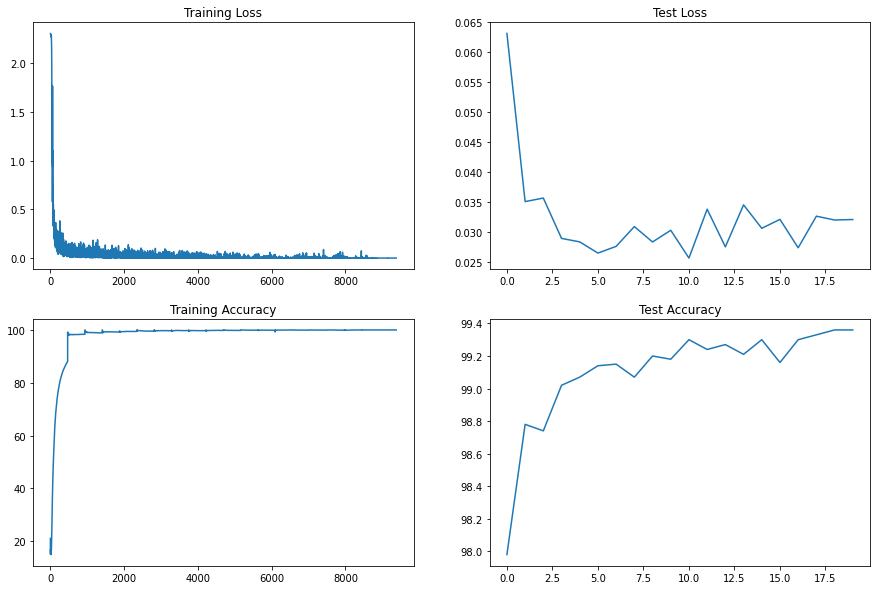

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

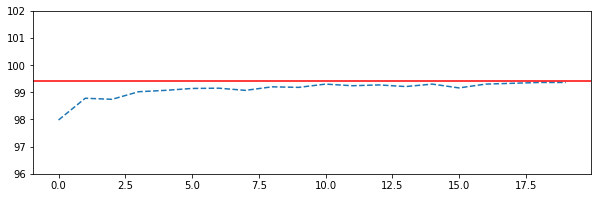

In [ ]:
ymin = 96
ymax = 102
plt.figure(figsize=(10, 3))
#plt.plot(train_acc, label = 'train_acc', linestyle = "--")
plt.plot(test_acc, label = 'test_acc', linestyle = "--")
plt.axhline(y=99.4, color='r', linestyle='-')
plt.ylim(ymin, ymax)
plt.show()

In [ ]:
print('Total Model Parameters : ', sum(p.numel() for p in model.parameters()))
print('Best Train Accuracy : ', max(train_acc))
print('Best Test Accuracy : ', max(test_acc))
x = [x for x in test_acc if x >= 99.4]
print('# of Epochs with test accuracy above 99.4% threshold:', len(x))

Total Model Parameters :  6379786
Best Train Accuracy :  100.0
Best Test Accuracy :  99.36
# of Epochs with test accuracy above 99.4% threshold: 0
